# Hanadi's Capstone Project (Personlized Recipe Recommendation)

## Background

Food is the source of energy, having food high in nutritional value is important to support the overall health. Being aware of the amount of nutrients in our food help us keep track of meeting our daily needs of energy and nutrients, thus maintaining our health. The availability of time to cook can vary from time to time, but that shouldn’t prevent us from having the same nutritious meals. For that, I wanted to create a Recommendation system that suggest a recipe based on user’s preference of main ingredients, time to cook, and nutritional information.

## Motivation

As someone who studied clinical nutrition and loves cooking, sometimes I don’t feel motivated to cook especially whenever I’m busy & don’t have enough time which sometimes reduces my diet quality. For that reason, I decided to create this recommendations system project that not only takes into account ingredients preference and nutritional value of the recipe but also the total time to cook to help me & everyone else to keep our diet quality despite of the time availability!

## Data

Original dataset contained 35,516 instances & 47 feature. The dataset was scrapped on May 2021 from a recipe website called Allrecipes and was used to provide insight of the nutritional value of various recipes. Original data obtained from this GitHub repo:
https://github.com/shaansubbaiah/allrecipes-scraper/tree/main/export

For this project, after cleaning the original dataset and saving it in data file as (full_cleaned_data).
The final data shape was 19,265 instances and 14 feature which are:
| Feature         | Description |
|  :---:          |   :---:     |
|  name           | recipe name |
| category        | recipe category, example (main dish, desserts, bread, world-cuisine ... ect) |
| rating          | recipe rating |
| rating count    | number of ratings |
| url             | link to this recipe |
| ingredients     | the original ingredients used in this recipe as scrapped from the website |
| total           | total recipe time (in minutes) preparation and cooking time |
| servings        | number of servings in this recipe |
| yield           | what will this recipe yield, example (4 servings, 3 cups, 12 cupcakes, ... ect) |
| calories        | amount of calories per serving |
| carbohydrates_g | grams of carbohydrate per serving |
| fat_g           | grams of fat per serving |
| protein_g       | grams of protein per serving |
| ingredients_parsed | ingredients after cleaning measurements, punctuations & common words|

## Libraries

In [1576]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
import re

import nltk
import string
import ast
import re
import unidecode
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter
import config



## Data preprocessing

### Data Cleaning

In [1577]:
##Read the data
Recipe = pd.read_csv("../data/scraped-07-05-21.csv", index_col=0)

In [1578]:
## original dataset shape
Recipe.shape


(35516, 47)

In [1579]:
### Check the dataset
Recipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35516 entries, 0 to 35515
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   35516 non-null  object 
 1   url                    35516 non-null  object 
 2   category               35516 non-null  object 
 3   author                 35475 non-null  object 
 4   summary                35516 non-null  object 
 5   rating                 35516 non-null  float64
 6   rating_count           35516 non-null  int64  
 7   review_count           35516 non-null  int64  
 8   ingredients            35516 non-null  object 
 9   directions             35516 non-null  object 
 10  prep                   33390 non-null  object 
 11  cook                   27857 non-null  object 
 12  total                  33564 non-null  object 
 13  servings               35516 non-null  int64  
 14  yield                  35515 non-null  object 
 15  ca

In [1580]:
##Check for duplicates
Recipe.duplicated().sum()

0

In [1581]:
##Drop the features that I don't need, for example: (author, summary, review_count, directions, sodium_mg, calories_from_fat, & all micronutirents)
Recipe.drop(['author', 'summary', 'review_count', 'directions', 'sugars_g', 'saturated_fat_g', 'cholesterol_mg', 'dietary_fiber_g', 'sodium_mg', 'calories_from_fat', 'prep', 'cook','calcium_mg', 'iron_mg', 'magnesium_mg', 'potassium_mg', 'vitamin_a_iu_IU', 'niacin_equivalents_mg', 'vitamin_c_mg', 'folate_mcg', 'thiamin_mg', 'zinc_mg', 'phosphorus_mg', 'vitamin_b6_mg', 'riboflavin_mg', 'vitamin_e_iu_IU', 'vitamin_k_mcg', 'biotin_mcg' , 'vitamin_b12_mcg', 'mono_fat_g', 'poly_fat_g', 'trans_fatty_acid_g', 'omega_3_fatty_acid_g', 'omega_6_fatty_acid_g'], axis=1, inplace=True )


In [1582]:
#Check shape after deleting unnecssary features
Recipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35516 entries, 0 to 35515
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             35516 non-null  object 
 1   url              35516 non-null  object 
 2   category         35516 non-null  object 
 3   rating           35516 non-null  float64
 4   rating_count     35516 non-null  int64  
 5   ingredients      35516 non-null  object 
 6   total            33564 non-null  object 
 7   servings         35516 non-null  int64  
 8   yield            35515 non-null  object 
 9   calories         35402 non-null  float64
 10  carbohydrates_g  35368 non-null  float64
 11  fat_g            35098 non-null  float64
 12  protein_g        35255 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 3.8+ MB


In [1583]:
## Look at the head before cleaning
Recipe.head(3)

,name,url,category,rating,rating_count,ingredients,total,servings,yield,calories,carbohydrates_g,fat_g,protein_g
0,Simple Macaroni and Cheese,https://www.allrecipes.com/recipe/238691/simpl...,main-dish,4.42,834,1 (8 ounce) box elbow macaroni ; ¼ cup butter ...,30 mins,4,4 servings,630.2,55.0,33.6,26.5
1,Gourmet Mushroom Risotto,https://www.allrecipes.com/recipe/85389/gourme...,main-dish,4.80,3388,"6 cups chicken broth, divided ; 3 tablespoons ...",50 mins,6,6 servings,430.6,56.6,16.6,11.3
2,Dessert Crepes,https://www.allrecipes.com/recipe/19037/desser...,breakfast-and-brunch,4.80,1156,"4 eggs, lightly beaten ; 1 ⅓ cups milk ; 2 ta...",20 mins,8,8 crepes,163.8,17.2,7.7,6.4


In [1584]:
##checking for missing calue
Recipe.isna().sum()
#Maximum missing values were in total cooking time was (1952) which represents 5% of the total data.
#All other missing values were in the nutrient information features  were less than (500).

name                  0
url                   0
category              0
rating                0
rating_count          0
ingredients           0
total              1952
servings              0
yield                 1
calories            114
carbohydrates_g     148
fat_g               418
protein_g           261
dtype: int64

In [1585]:
###Dealing with missing data, I'll drop the instences that doesn't contain the maximum missing values feature represents only 5% of the total data.

Recipe.dropna(inplace=True)
Recipe.isna().sum()


name               0
url                0
category           0
rating             0
rating_count       0
ingredients        0
total              0
servings           0
yield              0
calories           0
carbohydrates_g    0
fat_g              0
protein_g          0
dtype: int64

### Nutrition values features

In [1586]:

##Check the maximum values for nutrition values
Recipe.describe()


,rating,rating_count,servings,calories,carbohydrates_g,fat_g,protein_g
count,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000
mean,4.002661,136.172135,10.090357,318.526714,28.546888,16.734657,14.192982
std,1.372287,521.557650,11.517070,212.192220,24.092086,14.545362,14.063005
min,0.000000,0.000000,1.000000,0.100000,0.000000,0.000000,0.000000
25%,4.110000,4.000000,4.000000,167.625000,10.800000,6.700000,3.700000
50%,4.480000,21.000000,8.000000,280.000000,24.000000,13.300000,8.800000
75%,4.670000,88.000000,12.000000,421.900000,40.400000,22.900000,22.000000
max,5.000000,19358.000000,832.000000,4709.200000,578.200000,383.900000,273.200000


In [1587]:
##I found crazy large amount of max	serving=832, calories=4709.2, carbs=578.2, fat=383.9, protein=273.2
## So, I decided to put upper limit of calories at 1000 kcal, in which 50% are carbs = 125 g, 25% are fat = 28 g, and 25% are protein =63 g.
## For serving, the upper limit would be the 75th % = 12.

Recipe = Recipe[Recipe['calories'] <= 1000]
Recipe = Recipe[Recipe['fat_g'] <= 28]
Recipe = Recipe[Recipe['protein_g'] <= 63]
Recipe = Recipe[Recipe['carbohydrates_g'] <= 125]
Recipe = Recipe[Recipe['servings'] <= 12]

In [1588]:
##Check the again after setting up maximum limits
Recipe.describe()


,rating,rating_count,servings,calories,carbohydrates_g,fat_g,protein_g
count,21680.000000,21680.000000,21680.000000,21680.000000,21680.000000,21680.000000,21680.000000
mean,4.001043,133.255397,6.792435,277.063584,28.013247,12.604940,13.390392
std,1.359057,530.601374,3.106487,134.686314,20.640242,7.478032,11.464151
min,0.000000,0.000000,1.000000,3.200000,0.000000,0.000000,0.000000
25%,4.100000,4.000000,4.000000,176.175000,11.400000,6.500000,4.300000
50%,4.470000,21.000000,6.000000,266.750000,24.600000,12.000000,9.300000
75%,4.670000,86.000000,8.000000,364.600000,40.300000,18.500000,20.800000
max,5.000000,19358.000000,12.000000,904.000000,123.400000,28.000000,62.800000


### Total (cooking time) feature

In [1589]:
###Remove recipe that takes a week or longer to cook.
Recipe = Recipe[Recipe['total'] != 'week']

#searchforweek = ['week']
#Recipe = Recipe[~Recipe.total.str.contains('|'.join(searchforweek))]



In [1590]:
## Convert total from string to int
def humantime2minutes(s):
    d = {
      'd':      24*60,
      'day':    24*60,
      'days':   24*60,
      'hr':      60,
      'hrs':     60,
    }
    mult_items = defaultdict(lambda: 1).copy()
    mult_items.update(d)

    parts = re.search(r'^(\d+)([^\d]*)', s.lower().replace(' ', ''))
    if parts:
        return int(parts.group(1)) * mult_items[parts.group(2)] + humantime2minutes(re.sub(r'^(\d+)([^\d]*)', '', s.lower()))
    else:
        return 0
        

In [1591]:
#Apply the function to the column
Recipe['total'] = Recipe['total'].apply(humantime2minutes)


In [1592]:
##Check after cleaning
Recipe.describe()

,rating,rating_count,total,servings,calories,carbohydrates_g,fat_g,protein_g
count,21680.000000,21680.000000,21680.000000,21680.000000,21680.000000,21680.000000,21680.000000,21680.000000
mean,4.001043,133.255397,98.309779,6.792435,277.063584,28.013247,12.604940,13.390392
std,1.359057,530.601374,243.335854,3.106487,134.686314,20.640242,7.478032,11.464151
min,0.000000,0.000000,1.000000,1.000000,3.200000,0.000000,0.000000,0.000000
25%,4.100000,4.000000,25.000000,4.000000,176.175000,11.400000,6.500000,4.300000
50%,4.470000,21.000000,45.000000,6.000000,266.750000,24.600000,12.000000,9.300000
75%,4.670000,86.000000,80.000000,8.000000,364.600000,40.300000,18.500000,20.800000
max,5.000000,19358.000000,8642.000000,12.000000,904.000000,123.400000,28.000000,62.800000


### Ingredients feature

In [1593]:
### First, I'll drop recipe that contains (pork, wine, beer, alcohol) as these are inconvenient for the target audience

# Recipe = Recipe[Recipe['ingredients'] != 'pork']
# Recipe = Recipe[Recipe['ingredients'] != 'wine']
# Recipe = Recipe[Recipe['ingredients'] != 'beer']
# Recipe = Recipe[Recipe['ingredients'] != 'alcohol']
# Recipe = Recipe[Recipe['ingredients'] != 'vodka']
# Recipe = Recipe[Recipe['ingredients'] != 'whiskey']
# Recipe = Recipe[Recipe['ingredients'] != 'liqueur']

# searchforing = ['pork', 'wine', 'beer', 'alcohol', 'vodka', 'whiskey', 'liqueur']

Recipe = Recipe[~Recipe.ingredients.str.contains('vodka')]
Recipe = Recipe[~Recipe.ingredients.str.contains('pork')]
Recipe = Recipe[~Recipe.ingredients.str.contains('wine')]
Recipe = Recipe[~Recipe.ingredients.str.contains('alcohol')]
Recipe = Recipe[~Recipe.ingredients.str.contains('whiskey')]
Recipe = Recipe[~Recipe.ingredients.str.contains('liqueur')]


In [1594]:
### Convert the ingredients column to a list
Recipe['ingredients'] = Recipe['ingredients'].str.strip('()').str.split(';')



In [1595]:
##save to new csv
#Recipe.to_csv('cleaned_data.csv', index = False)

In [1596]:
## use function by whatscooking-deployment. Reference (https://github.com/jackmleitch/whatscooking-deployment)
def ingredient_parser(ingreds):
    measures = [
        "teaspoon",
        "t",
        "tsp.",
        "tablespoon",
        "T",
        "tbl.",
        "tb",
        "tbsp.",
        "fluid ounce",
        "fl oz",
        "gill",
        "cup",
        "c",
        "pint",
        "p",
        "pt",
        "fl pt",
        "quart",
        "q",
        "qt",
        "fl qt",
        "gallon",
        "g",
        "gal",
        "ml",
        "milliliter",
        "millilitre",
        "cc",
        "mL",
        "l",
        "liter",
        "litre",
        "L",
        "dl",
        "deciliter",
        "decilitre",
        "dL",
        "bulb",
        "level",
        "heaped",
        "rounded",
        "whole",
        "pinch",
        "medium",
        "slice",
        "pound",
        "lb",
        "#",
        "ounce",
        "oz",
        "mg",
        "milligram",
        "milligramme",
        "g",
        "gram",
        "gramme",
        "kg",
        "kilogram",
        "kilogramme",
        "x",
        "of",
        "mm",
        "millimetre",
        "millimeter",
        "cm",
        "centimeter",
        "centimetre",
        "m",
        "meter",
        "metre",
        "inch",
        "in",
        "milli",
        "centi",
        "deci",
        "hecto",
        "kilo",
    ]
    words_to_remove = [
        "fresh",
        "minced",
        "chopped" "oil",
        "a",
        "red",
        "bunch",
        "and",
        "clove",
        "or",
        "leaf",
        "chilli",
        "large",
        "extra",
        "sprig",
        "ground",
        "handful",
        "free",
        "small",
        "pepper",
        "virgin",
        "range",
        "from",
        "dried",
        "sustainable",
        "black",
        "peeled",
        "higher",
        "welfare",
        "seed",
        "for",
        "finely",
        "freshly",
        "sea",
        "quality",
        "white",
        "ripe",
        "few",
        "piece",
        "source",
        "to",
        "organic",
        "flat",
        "smoked",
        "ginger",
        "sliced",
        "green",
        "picked",
        "the",
        "stick",
        "plain",
        "plus",
        "mixed",
        "mint",
        "bay",
        "basil",
        "your",
        "cumin",
        "optional",
        "fennel",
        "serve",
        "mustard",
        "unsalted",
        "baby",
        "paprika",
        "fat",
        "ask",
        "natural",
        "skin",
        "roughly",
        "into",
        "such",
        "cut",
        "good",
        "brown",
        "grated",
        "trimmed",
        "oregano",
        "powder",
        "yellow",
        "dusting",
        "knob",
        "frozen",
        "on",
        "deseeded",
        "low",
        "runny",
        "balsamic",
        "cooked",
        "streaky",
        "nutmeg",
        "sage",
        "rasher",
        "zest",
        "pin",
        "groundnut",
        "breadcrumb",
        "turmeric",
        "halved",
        "grating",
        "stalk",
        "light",
        "tinned",
        "dry",
        "soft",
        "rocket",
        "bone",
        "colour",
        "washed",
        "skinless",
        "leftover",
        "splash",
        "removed",
        "dijon",
        "thick",
        "big",
        "hot",
        "drained",
        "sized",
        "chestnut",
        "watercress",
        "fishmonger",
        "english",
        "dill",
        "caper",
        "raw",
        "worcestershire",
        "flake",
        "cider",
        "cayenne",
        "tbsp",
        "leg",
        "pine",
        "wild",
        "if",
        "fine",
        "herb",
        "almond",
        "shoulder",
        "cube",
        "dressing",
        "with",
        "chunk",
        "spice",
        "thumb",
        "garam",
        "new",
        "little",
        "punnet",
        "peppercorn",
        "shelled",
        "saffron",
        "other" "chopped",
        "salt",
        "olive",
        "taste",
        "can",
        "sauce",
        "water",
        "diced",
        "package",
        "italian",
        "shredded",
        "divided",
        "parsley",
        "vinegar",
        "all",
        "purpose",
        "crushed",
        "juice",
        "more",
        "coriander",
        "bell",
        "needed",
        "thinly",
        "boneless",
        "half",
        "thyme",
        "cubed",
        "cinnamon",
        "cilantro",
        "jar",
        "seasoning",
        "rosemary",
        "extract",
        "sweet",
        "baking",
        "beaten",
        "heavy",
        "seeded",
        "tin",
        "vanilla",
        "uncooked",
        "crumb",
        "style",
        "thin",
        "nut",
        "coarsely",
        "spring",
        "chili",
        "cornstarch",
        "strip",
        "cardamom",
        "rinsed",
        "honey",
        "cherry",
        "root",
        "quartered",
        "head",
        "softened",
        "container",
        "crumbled",
        "frying",
        "lean",
        "cooking",
        "roasted",
        "warm",
        "whipping",
        "thawed",
        "corn",
        "pitted",
        "sun",
        "kosher",
        "bite",
        "toasted",
        "lasagna",
        "split",
        "melted",
        "degree",
        "lengthwise",
        "romano",
        "packed",
        "pod",
        "anchovy",
        "rom",
        "prepared",
        "juiced",
        "fluid",
        "floret",
        "room",
        "active",
        "seasoned",
        "mix",
        "deveined",
        "lightly",
        "anise",
        "thai",
        "size",
        "unsweetened",
        "torn",
        "wedge",
        "sour",
        "basmati",
        "marinara",
        "dark",
        "temperature",
        "garnish",
        "bouillon",
        "loaf",
        "shell",
        "reggiano",
        "canola",
        "parmigiano",
        "round",
        "canned",
        "ghee",
        "crust",
        "long",
        "broken",
        "ketchup",
        "bulk",
        "cleaned",
        "condensed",
        "sherry",
        "provolone",
        "cold",
        "soda",
        "cottage",
        "spray",
        "tamarind",
        "pecorino",
        "shortening",
        "part",
        "bottle",
        "sodium",
        "cocoa",
        "grain",
        "french",
        "roast",
        "stem",
        "link",
        "firm",
        "asafoetida",
        "mild",
        "dash",
        "boiling",
        "oil",
        "chopped",
        "vegetable oil",
        "chopped oil",
        "garlic",
        "skin off",
        "bone out" "from sustrainable sources",
    ]
    # The ingredient list is now a string so we need to turn it back into a list. We use ast.literal_eval
    if isinstance(ingreds, list):
        ingredients = ingreds
    else:
        ingredients = ast.literal_eval(ingreds)
    # We first get rid of all the punctuation. We make use of str.maketrans. It takes three input
    # arguments 'x', 'y', 'z'. 'x' and 'y' must be equal-length strings and characters in 'x'
    # are replaced by characters in 'y'. 'z' is a string (string.punctuation here) where each character
    #  in the string is mapped to None.
    translator = str.maketrans("", "", string.punctuation)
    lemmatizer = WordNetLemmatizer()
    ingred_list = []
    for i in ingredients:
        i.translate(translator)
        # We split up with hyphens as well as spaces
        items = re.split(" |-", i)
        # Get rid of words containing non alphabet letters
        items = [word for word in items if word.isalpha()]
        # Turn everything to lowercase
        items = [word.lower() for word in items]
        # remove accents
        items = [
            unidecode.unidecode(word) for word in items
        ]  #''.join((c for c in unicodedata.normalize('NFD', items) if unicodedata.category(c) != 'Mn'))
        # Lemmatize words so we can compare words to measuring words
        items = [lemmatizer.lemmatize(word) for word in items]
        # Gets rid of measuring words/phrases, e.g. heaped teaspoon
        items = [word for word in items if word not in measures]
        # Get rid of common easy words
        items = [word for word in items if word not in words_to_remove]
        if items:
            ingred_list.append(" ".join(items))
    # ingred_list = " ".join(ingred_list)
    return ingred_list

In [1597]:
##Apply the function to ingredients column
if __name__ == "__main__":
    Recipe = pd.read_csv(config.RECIPES_PATH)
    Recipe["ingredients_parsed"] = Recipe["ingredients"].apply(
        lambda x: ingredient_parser(x)
    )

In [1599]:
##Look at the dataset agfter adding the column
Recipe.head(3)

,name,url,category,rating,rating_count,ingredients,total,servings,yield,calories,carbohydrates_g,fat_g,protein_g,ingredients_parsed
0,Dessert Crepes,https://www.allrecipes.com/recipe/19037/desser...,breakfast-and-brunch,4.80,1156,"['4 eggs', ' lightly beaten ; 1\u2009⅓ cups m...",20,8,8 crepes,163.8,17.2,7.7,6.4,"[egg, milk butter, flour sugar]"
1,Chicken Parmesan,https://www.allrecipes.com/recipe/223042/chick...,world-cuisine,4.83,4245,"['4 skinless', ' boneless chicken breast halv...",60,4,4 servings,470.8,24.8,24.9,42.1,"[chicken breast egg panko bread, parmesan chee..."
2,Easy Sausage Gravy and Biscuits,https://www.allrecipes.com/recipe/216391/easy-...,trusted-brands-recipes-and-tips,4.81,1063,['1 (16 ounce) can refrigerated jumbo buttermi...,15,8,8 servings,332.8,30.8,18.7,9.8,[refrigerated jumbo buttermilk biscuit jimmy o...


### Name feature

In [1600]:
###Remove certain recipes such as (seasonings, animal treat) <<< WHY IT AINT WORKING :')???

# Recipe = Recipe[Recipe['name'] != 'Seasonings']
# Recipe = Recipe[Recipe['name'] != 'Seasoning']
# Recipe = Recipe[Recipe['name'] != 'Treat']

# recname = ['seasonings', 'seasoning', 'treat']

Recipe = Recipe[~Recipe.name.str.contains('Seasoning')]
Recipe = Recipe[~Recipe.name.str.contains('Treat')]



Recipe.sort_values('name')

,name,url,category,rating,rating_count,ingredients,total,servings,yield,calories,carbohydrates_g,fat_g,protein_g,ingredients_parsed
18574,"""AWW NUTS!"" Pecan Pie Minis",https://www.allrecipes.com/recipe/256133/aww-n...,desserts,3.00,1,['4 ounces reduced-fat cream cheese (Neufchate...,90,12,12 mini pies,194.8,19.3,11.7,4.0,"[reduced cream cheese, tub vegetable spread fl..."
13841,"""Doritos®"" Popcorn",https://www.allrecipes.com/recipe/244171/dorit...,appetizers-and-snacks,4.08,12,['¼ cup nutritional yeast ; 2 teaspoons salt (...,10,4,4 servings,95.9,16.8,1.3,6.3,"[nutritional yeast real onion, popcorn, desired]"
14942,"""Light as a Feather"" Scones",https://www.allrecipes.com/recipe/233529/light...,bread,4.38,16,['cooking spray ; 2 cups sifted all-purpose fl...,30,8,8 scones,239.2,35.2,8.5,5.3,"[sifted flour sugar butter, reduced yogurt egg..."
15644,"""Nutcracker"" Mixed-Nut Brittle in the Microwave",https://www.allrecipes.com/recipe/277972/nutcr...,desserts,0.00,0,['1 serving cooking spray ; 1 cup white sugar...,40,12,12 servings,214.6,31.5,9.8,3.0,"[serving sugar syrup butter, coarse]"
2076,"""PERFECTLY CHOCOLATE"" Chocolate Cake",https://www.allrecipes.com/recipe/261176/perfe...,trusted-brands-recipes-and-tips,4.51,43,"[""2 cups sugar ; 1\u2009¾ cups all-purpose flo...",50,12,12 servings,527.6,84.4,19.4,5.8,[sugar flour egg milk vegetable butter margari...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16977,Zucchini-Sausage Mini Pizzas,https://www.allrecipes.com/recipe/274996/zucch...,appetizers-and-snacks,0.00,0,"['½ cup butter', ' melted ; 3 cloves crushed g...",35,10,10 servings,273.8,4.8,24.5,9.1,"[butter, zucchini, crosswise sausage pizza moz..."
15675,Zucchini-Tomato Saute,https://www.allrecipes.com/recipe/13894/zucchi...,side-dish,4.17,105,"['1 tablespoon vegetable oil ; 1 onion', ' sl...",45,6,6 servings,93.9,16.1,2.8,3.2,"[vegetable onion, tomato, zucchini, rice]"
11970,Zuppa di Orzo e Fagioli (Bean and Barley Soup),https://www.allrecipes.com/recipe/246043/zuppa...,soups-stews-and-chili,4.00,1,['½ pound pearl barley ; 2 tablespoons extra-v...,125,4,4 servings,535.9,77.2,17.6,17.6,"[pearl barley pancetta bacon, onion, carrot, c..."
17828,Zurie's Fresh Fig Compote Over Cream Cheese,https://www.allrecipes.com/recipe/228559/zurie...,appetizers-and-snacks,4.50,10,['⅔ cup brown sugar ; ¼ cup water ; 1 pinch sa...,25,8,8 servings,175.7,20.6,9.9,2.4,"[sugar fig, stemmed cream cheese]"


In [1601]:
###Take a look at dataset after cleaning
Recipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19265 entries, 0 to 19311
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                19265 non-null  object 
 1   url                 19265 non-null  object 
 2   category            19265 non-null  object 
 3   rating              19265 non-null  float64
 4   rating_count        19265 non-null  int64  
 5   ingredients         19265 non-null  object 
 6   total               19265 non-null  int64  
 7   servings            19265 non-null  int64  
 8   yield               19265 non-null  object 
 9   calories            19265 non-null  float64
 10  carbohydrates_g     19265 non-null  float64
 11  fat_g               19265 non-null  float64
 12  protein_g           19265 non-null  float64
 13  ingredients_parsed  19265 non-null  object 
dtypes: float64(5), int64(3), object(6)
memory usage: 2.2+ MB


In [1602]:
##Checkout the head of dataset after cleaning
Recipe.head(3)

,name,url,category,rating,rating_count,ingredients,total,servings,yield,calories,carbohydrates_g,fat_g,protein_g,ingredients_parsed
0,Dessert Crepes,https://www.allrecipes.com/recipe/19037/desser...,breakfast-and-brunch,4.80,1156,"['4 eggs', ' lightly beaten ; 1\u2009⅓ cups m...",20,8,8 crepes,163.8,17.2,7.7,6.4,"[egg, milk butter, flour sugar]"
1,Chicken Parmesan,https://www.allrecipes.com/recipe/223042/chick...,world-cuisine,4.83,4245,"['4 skinless', ' boneless chicken breast halv...",60,4,4 servings,470.8,24.8,24.9,42.1,"[chicken breast egg panko bread, parmesan chee..."
2,Easy Sausage Gravy and Biscuits,https://www.allrecipes.com/recipe/216391/easy-...,trusted-brands-recipes-and-tips,4.81,1063,['1 (16 ounce) can refrigerated jumbo buttermi...,15,8,8 servings,332.8,30.8,18.7,9.8,[refrigerated jumbo buttermilk biscuit jimmy o...


In [1603]:

###save to csv 
#Recipe.to_csv('full_clean_data.csv', index = False)


## EDA

In [1604]:
##Summary statisitcs
Recipe.describe()

,rating,rating_count,total,servings,calories,carbohydrates_g,fat_g,protein_g
count,19265.000000,19265.000000,19265.000000,19265.000000,19265.000000,19265.000000,19265.000000,19265.000000
mean,3.984249,131.915858,94.906255,6.870127,273.052510,28.370947,12.477794,12.780042
std,1.374463,541.767441,244.957290,3.135134,132.949772,20.560194,7.463413,11.091237
min,0.000000,0.000000,1.000000,1.000000,4.000000,0.100000,0.000000,0.000000
25%,4.070000,4.000000,25.000000,4.000000,172.500000,11.800000,6.400000,4.200000
50%,4.460000,20.000000,45.000000,6.000000,262.500000,25.100000,11.800000,8.600000
75%,4.670000,84.000000,80.000000,8.000000,360.300000,40.700000,18.300000,19.700000
max,5.000000,19358.000000,8642.000000,12.000000,873.000000,123.400000,28.000000,62.800000


In [1605]:
##Correlation matrix
Recipe.corr().style.background_gradient()

,rating,rating_count,total,servings,calories,carbohydrates_g,fat_g,protein_g
rating,1.000000,0.097934,0.012221,0.017397,0.000123,-0.006760,0.015858,-0.016869
rating_count,0.097934,1.000000,0.001972,0.039045,0.040771,0.020128,0.033630,0.028074
total,0.012221,0.001972,1.000000,0.112288,0.006679,0.019423,-0.027357,0.019036
servings,0.017397,0.039045,0.112288,1.000000,-0.136442,-0.016191,-0.051560,-0.300029
calories,0.000123,0.040771,0.006679,-0.136442,1.000000,0.710453,0.713016,0.595024
carbohydrates_g,-0.006760,0.020128,0.019423,-0.016191,0.710453,1.000000,0.148597,0.095316
fat_g,0.015858,0.033630,-0.027357,-0.051560,0.713016,0.148597,1.000000,0.367471
protein_g,-0.016869,0.028074,0.019036,-0.300029,0.595024,0.095316,0.367471,1.000000


Insight: As expected, there's a correlation between calories and carb, fat & protein. Additionally, fat correlated with protein


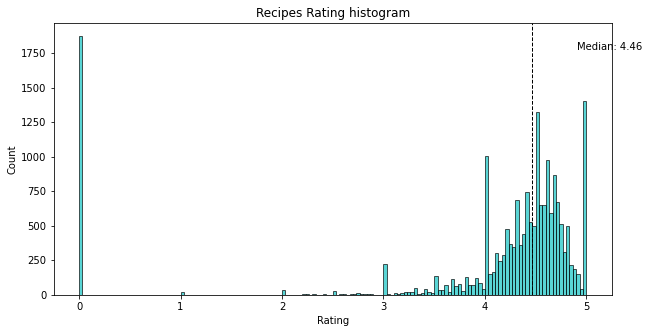

In [1606]:
##Rating distribution
plt.figure(figsize=(10,5))
np.random.seed(6789)
x = Recipe['rating']
result = plt.hist(x, bins=150, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(x.median()))
plt.title('Recipes Rating histogram')
plt.xlabel('Rating')
plt.ylabel('Count');

Insight: Most of recipe were not rated. For the rated recipe, the distribution seems negatively skewed & most of the rated recipe has rating of 5.

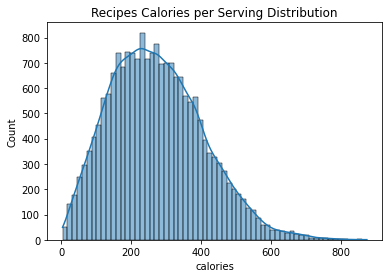

In [1607]:
##Calories/protein/carb/fat distribution
sns.histplot(Recipe.calories, kde=True)
plt.title('Recipes Calories per Serving Distribution');

Inight: The recipes calories seems positively skewed

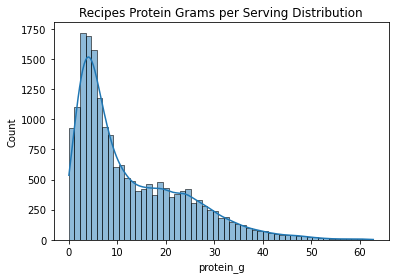

In [1608]:
sns.histplot(Recipe.protein_g, kde=True)
plt.title('Recipes Protein Grams per Serving Distribution');

Inight: The protein seems positively skewed.

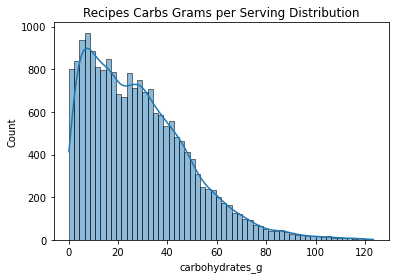

In [1609]:
sns.histplot(Recipe.carbohydrates_g, kde=True)
plt.title('Recipes Carbs Grams per Serving Distribution');

Inight: The carbs seems positively skewed.

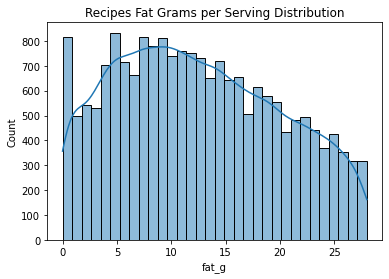

In [1610]:
sns.histplot(Recipe.fat_g, kde=True)
plt.title('Recipes Fat Grams per Serving Distribution');

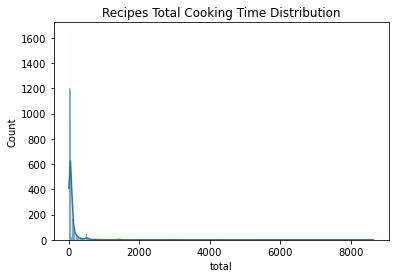

In [1611]:
##Total time distribution
sns.histplot(Recipe.total, kde=True)
plt.title('Recipes Total Cooking Time Distribution');

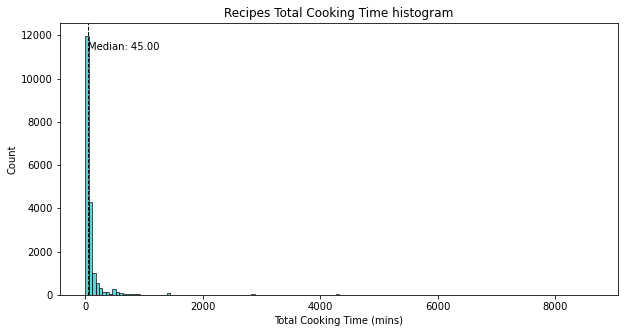

In [1612]:
##Total time distribution
plt.figure(figsize=(10,5))
np.random.seed(6789)
x = Recipe['total']
result = plt.hist(x, bins=150, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.median(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.median()*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(x.median()))
plt.title('Recipes Total Cooking Time histogram')
plt.xlabel('Total Cooking Time (mins)')
plt.ylabel('Count');

Insight: Time was positively skewed, most of recipes takes lower time to cook

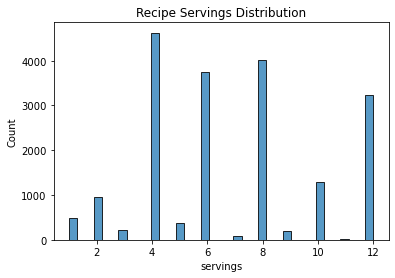

In [1613]:
##Servings distribution
sns.histplot(Recipe.servings)
plt.title('Recipe Servings Distribution');

Insight: Most recipe has 4 servings

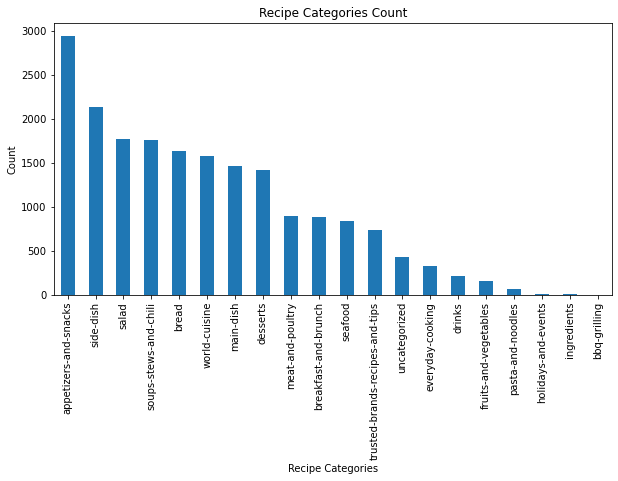

In [1614]:

##Recipe category count
category_count = Recipe.category.value_counts()
plt.figure(figsize=(10,5))
category_count.plot.bar( x = "Recipe Categories")
plt.title("Recipe Categories Count")
plt.xlabel("Recipe Categories")
plt.ylabel("Count");

Insight: Most of the recipe where appetizers & snacks

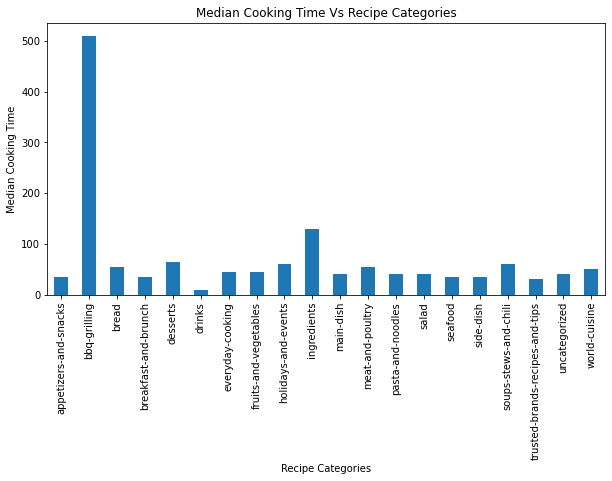

In [1615]:
##Total time vs recipe category
Med_time_category = Recipe.groupby(['category'])['total'].median()
plt.figure(figsize=(10,5))
Med_time_category.plot.bar( x = "Recipe Categories")
plt.title("Median Cooking Time Vs Recipe Categories")
plt.xlabel("Recipe Categories")
plt.ylabel("Median Cooking Time");

Insight: BBQ has the heighest median time whereas drinks has the least

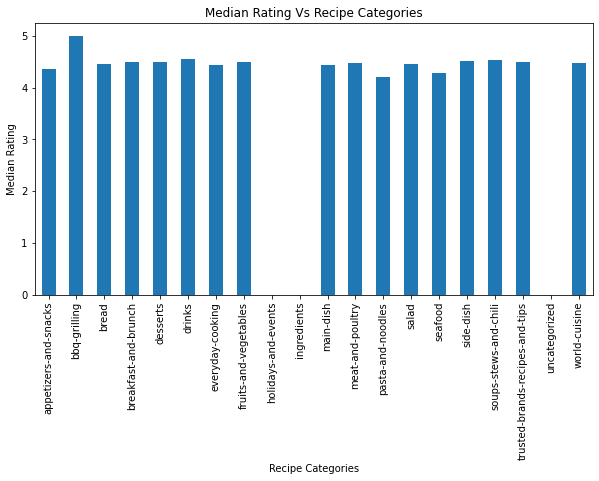

In [1616]:
##Rating (median) vs recipe category
Med_rate_category = Recipe.groupby(['category'])['rating'].median()
plt.figure(figsize=(10,5))
Med_rate_category.plot.bar( x = "Recipe Categories")
plt.title("Median Rating Vs Recipe Categories")
plt.xlabel("Recipe Categories")
plt.ylabel("Median Rating");

Insight: Median rating are closely similar between categories with BBQ having the heighest median rating

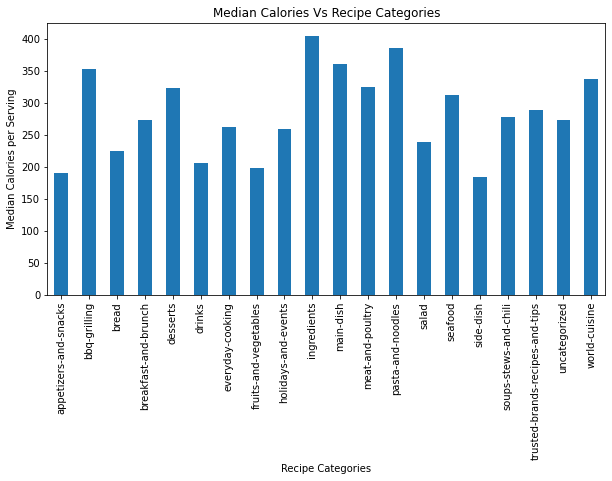

In [1617]:
##Calories (median) vs recipe category
Med_calories_category = Recipe.groupby(['category'])['calories'].median()
plt.figure(figsize=(10,5))
Med_calories_category.plot.bar( x = "Recipe Categories")
plt.title("Median Calories Vs Recipe Categories")
plt.xlabel("Recipe Categories")
plt.ylabel("Median Calories per Serving");


Insight: Pasta & noodles category has the heighest calories mean, whereas appetizers & side-dishes has the lowest mean

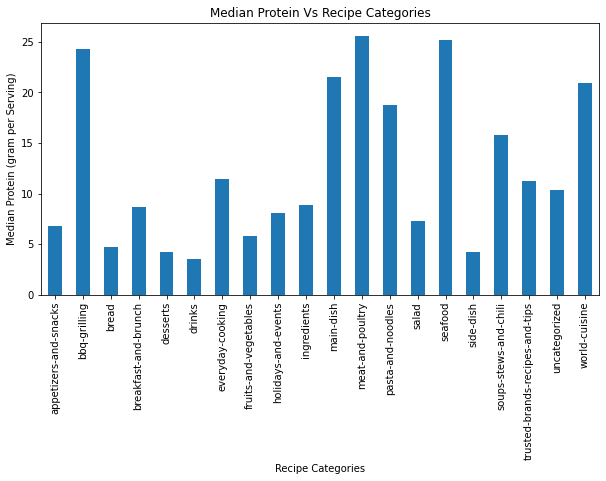

In [1618]:
##protein (median) vs recipe category
Med_pro_category = Recipe.groupby(['category'])['protein_g'].median()
plt.figure(figsize=(10,5))
Med_pro_category.plot.bar( x = "Recipe Categories")
plt.title("Median Protein Vs Recipe Categories")
plt.xlabel("Recipe Categories")
plt.ylabel("Median Protein (gram per Serving)");


Insight: Meat & poultry has the heighest protein per serving median followed by seafood & BBQ

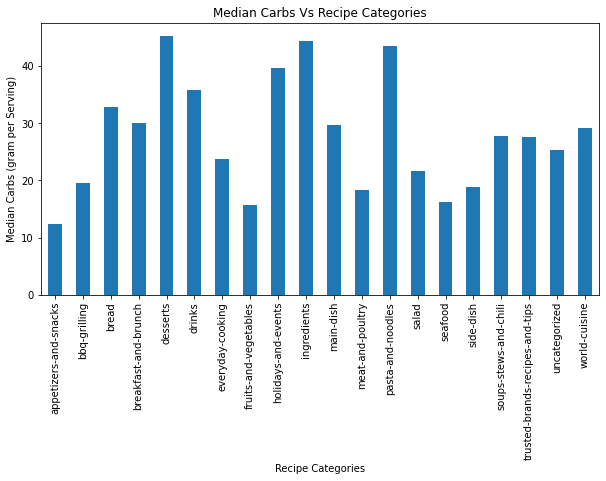

In [1619]:
##carb (median) vs recipe category
Med_carb_category = Recipe.groupby(['category'])['carbohydrates_g'].median()
plt.figure(figsize=(10,5))
Med_carb_category.plot.bar( x = "Recipe Categories")
plt.title("Median Carbs Vs Recipe Categories")
plt.xlabel("Recipe Categories")
plt.ylabel("Median Carbs (gram per Serving)");

Insight: As expected, desert has the heighest carbohydrates median, whereas appetizers had the lowest

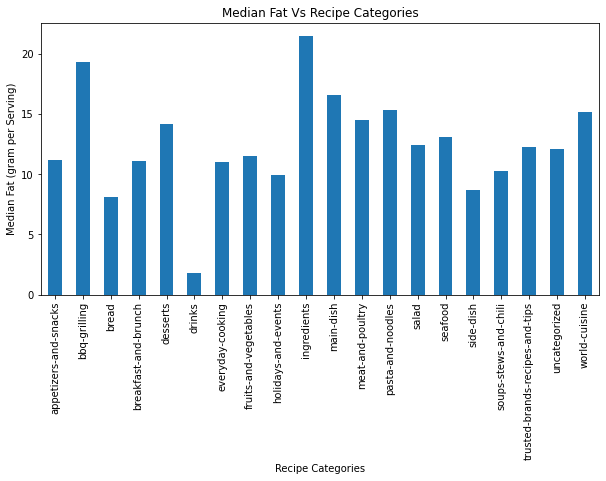

In [1620]:
##fat (median) vs recipe category
Med_fat_category = Recipe.groupby(['category'])['fat_g'].median()
plt.figure(figsize=(10,5))
Med_fat_category.plot.bar( x = "Recipe Categories")
plt.title("Median Fat Vs Recipe Categories")
plt.xlabel("Recipe Categories")
plt.ylabel("Median Fat (gram per Serving)");


Insight: Ingredients category has the heighest fat median, whereas drinks has the lowest

## Content-based Recommendation system

#### Features extraction

For ingredients:
- Bag of words\
OR
- TF-IDF (term frequencies-inverse document frequency)

#### Measure similarity between documents

Cosine similarity, Spacy, KNN

## Functional Website

I will be using (Streamlit or DASH or Flask) to build the functional website

Input will be 
1. Ingredients (Limit entry to 3 ingredients?)
2. Time will be categorized into ranges:
- < = 10 mins
- < = 15 mins
- < = 20 mins
- < = 30 mins
- < = 45 mins
- < = 60 mins (1 hr)
- < = 120 mins (2 hrs)
- < = 180 mins (3 hrs)
- <= 360 mins (6 hrs)
- <= 480 mind (8 hrs)
- <= 1440 mins (1 Day)
- <= 4320 mins (3 Days)
- <= 8642 mins (6 Days, Max/no time limit)
3. Calorie will be categorized into range: 
- <= 50 calories
- <=100 calories
- <=200 calories
- <=300 calories
- <=400 calories
- <=500 calories
- <=600 calories
- <=700 calories
- <=800 calories
- <=900 calories
- <=1000 calories (Max/no calories limit)
4. Carbohydrate range
- <=10 gm/serving
- <=20 gm/serving
- <=30 gm/serving
- <=40 gm/serving
- <=50 gm/serving
- <=60 gm/serving
- <=70 gm/serving
- <=80 gm/serving
- <=90 gm/serving
- <=100 gm/serving
- <= 125 gm/serving (Max/no carbs limit)
5. Protein range
- <=10 gm/serving
- <=20 gm/serving
- <=30 gm/serving
- <=40 gm/serving
- <=50 gm/serving
- <=63 gm/serving (Max/no carbs limit)
6. Fat range 
- <=5 gm/serving
- <=10 gm/serving
- <=15 gm/serving
- <=20 gm/serving
- <=25 gm/serving
- <=30 gm/serving (Max/no carbs limit)

Out put will be top the 3-5 recipes that matches the input criteria
1. Recipe name
2. Recipe url
3. Recipe actual nutrition info
4. Recipe Servings